In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf

In [2]:
sp_yf = yf.download('^GSPC', start = '2007-01-12', end = '2024-01-22', progress=False)
vix_yf = yf.download('^VIX',start = '2007-01-12', end = '2024-01-22', progress=False)
skew_yf = yf.download('^SKEW',start = '2007-01-12', end = '2024-01-22', progress=False)

sp_rnd = pd.read_csv('data/sp6m_6.csv')
sp_rnd['Date'] =pd.to_datetime(sp_rnd['idt'], format='%m/%d/%y')
sp_rnd = sp_rnd.set_index('Date')
sp_rnd.drop('idt',axis= 1, inplace=True)

sp_rnd['dec_plus_inc'] = sp_rnd['prDec'] + sp_rnd['prInc']
sp_rnd['dec_minus_inc'] = sp_rnd['prDec'] - sp_rnd['prInc']

In [3]:
full_df = sp_rnd.merge(sp_yf, how = 'left', left_index=True, right_index=True)
full_df['VIX'] = vix_yf['Close'].shift(-1)
full_df['SKEW'] = skew_yf['Close']

In [4]:
full_df.columns

Index(['market', 'maturity_target', 'mu', 'sd', 'skew', 'kurt', 'p10', 'p50',
       'p90', 'lg_change_decr', 'prDec', 'lg_change_incr', 'prInc',
       'dec_plus_inc', 'dec_minus_inc', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'VIX', 'SKEW'],
      dtype='object')

[]

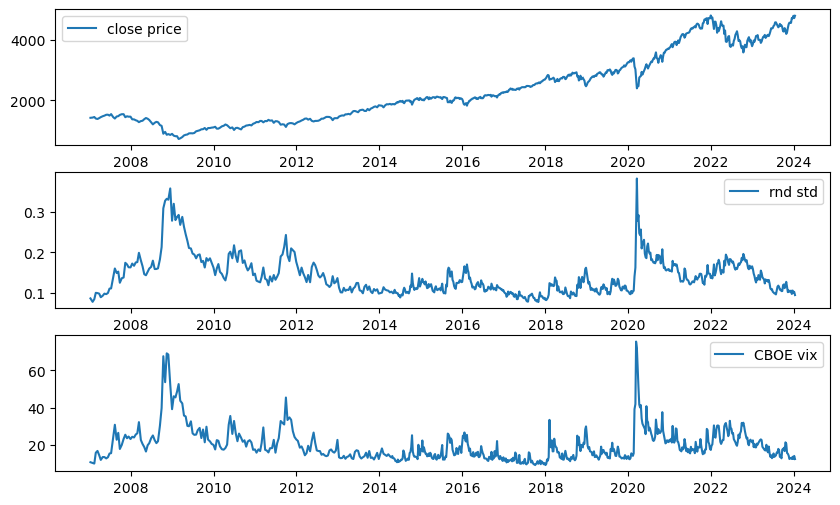

In [5]:
fig, axes = plt.subplots(3,1,figsize=(10, 6))

axes[0].plot(full_df.index,full_df['Close'], label = 'close price')
axes[1].plot(full_df.index,full_df['sd'], label = 'rnd std')
axes[2].plot(full_df.index,full_df['VIX'], label = 'CBOE vix')

axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.plot()

In [38]:
sp_yf['return'] = np.log(sp_yf['Close']/sp_yf['Close'].shift(1))

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=10)
sp_yf['forward_rv'] = np.sqrt((sp_yf['return']**2).rolling(window=indexer, min_periods=1).sum())

In [39]:
full_df['forward_vol'] = sp_yf['forward_rv']

[]

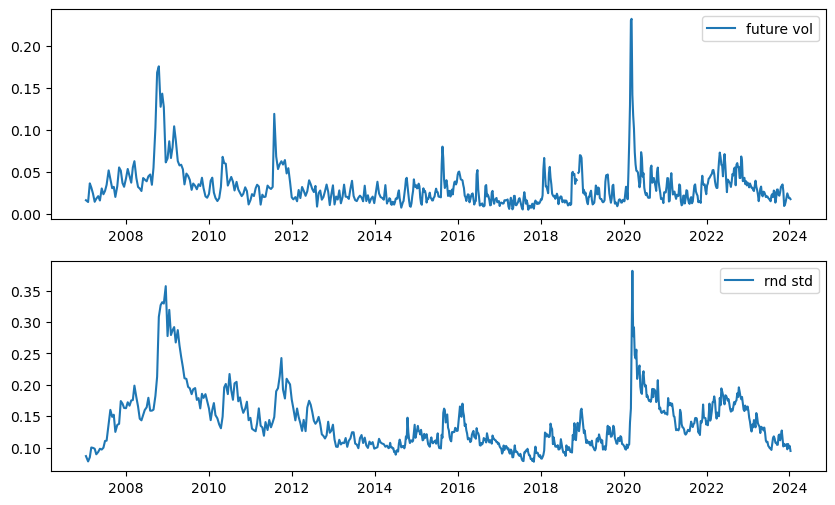

In [40]:
fig, axes = plt.subplots(2,1,figsize=(10, 6))

axes[0].plot(full_df.index,full_df['forward_vol'], label = 'future vol')
axes[1].plot(full_df.index,full_df['sd'], label = 'rnd std')

axes[0].legend()
axes[1].legend()
plt.plot()

In [41]:
import statsmodels.api as sm
import seaborn as sns

new = full_df[['sd','forward_vol']].copy().dropna()
X = new.iloc[:, :-1]
y = new.iloc[:,-1]

X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()
print('Regreesion results:')
print(result.summary())

Regreesion results:
                            OLS Regression Results                            
Dep. Variable:            forward_vol   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     572.7
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           2.34e-92
Time:                        21:31:50   Log-Likelihood:                 1817.0
No. Observations:                 684   AIC:                            -3630.
Df Residuals:                     682   BIC:                            -3621.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0187      0.002

[]

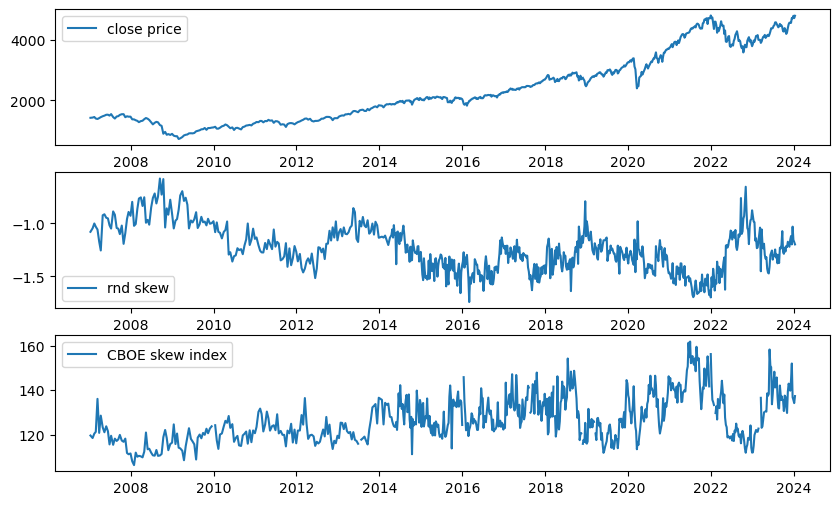

In [42]:
fig, axes = plt.subplots(3,1,figsize=(10, 6))

axes[0].plot(full_df.index,full_df['Close'], label = 'close price')
axes[1].plot(full_df.index,full_df['skew'], label = 'rnd skew')
axes[2].plot(full_df.index,full_df['SKEW'], label = 'CBOE skew index')

axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.plot()